File successfully saved to: C:\Users\fdkmu\OneDrive\labeledsensor2_data_file.csv

Test Data Performance:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Cross-Validation Performance:
Accuracy: 99.85%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


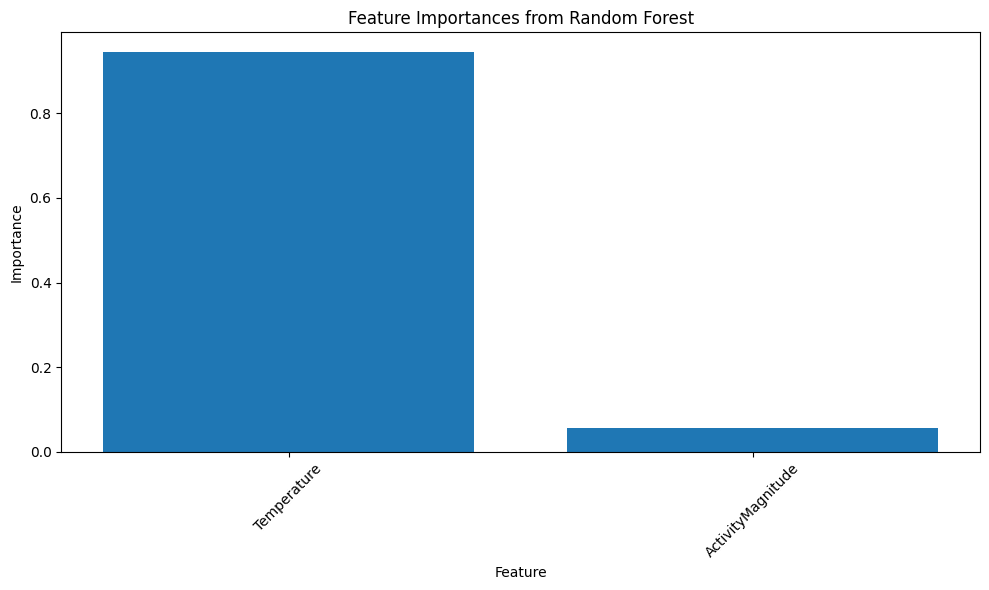

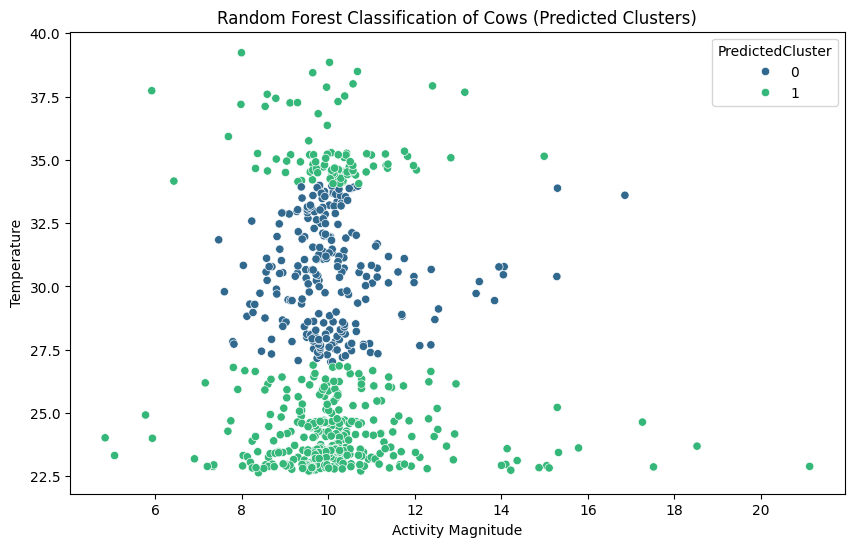

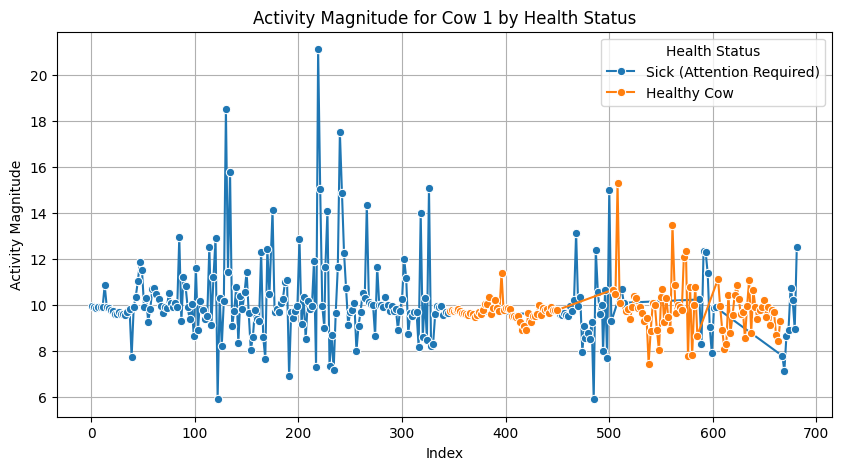

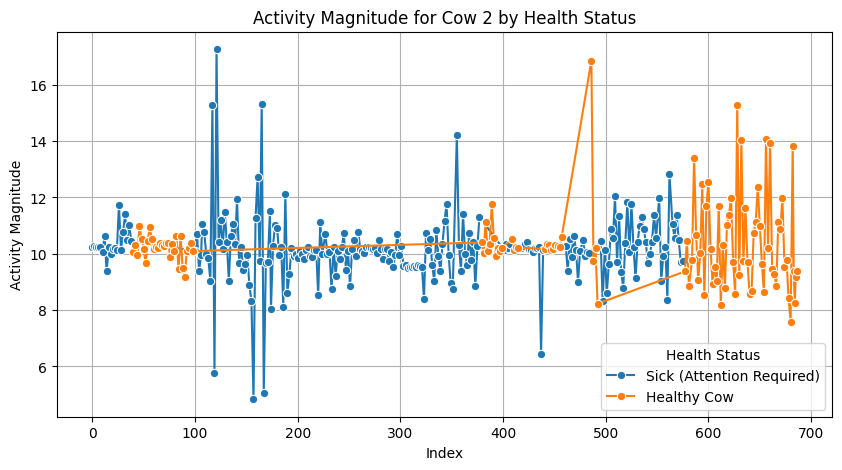

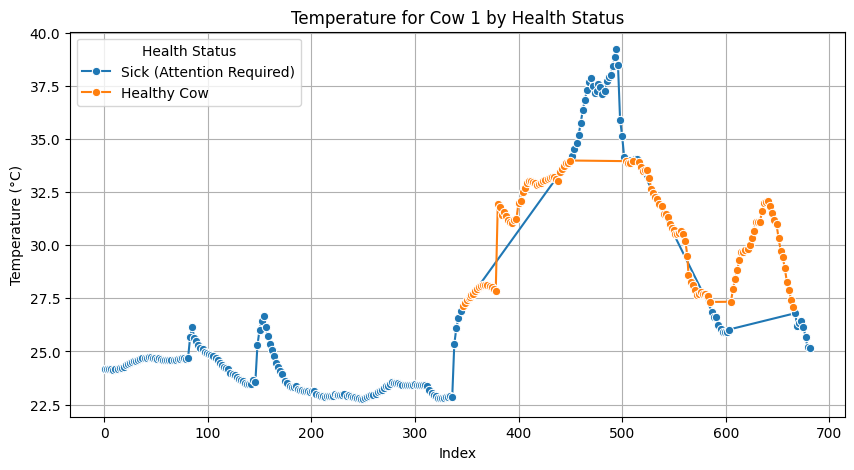

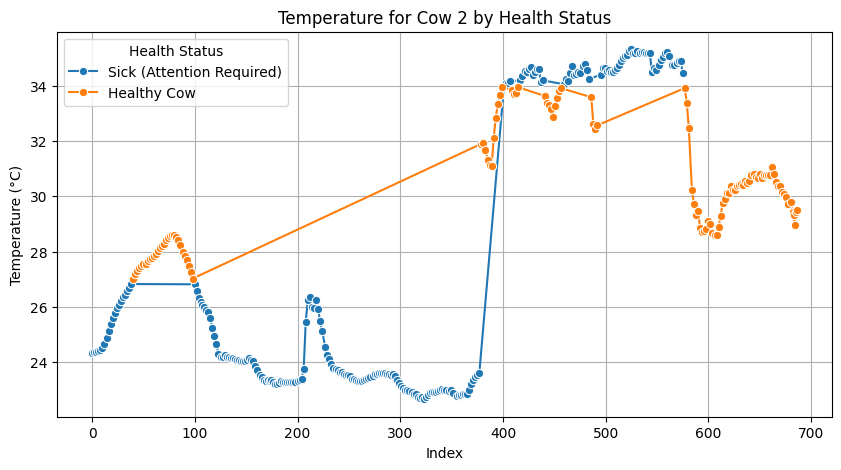

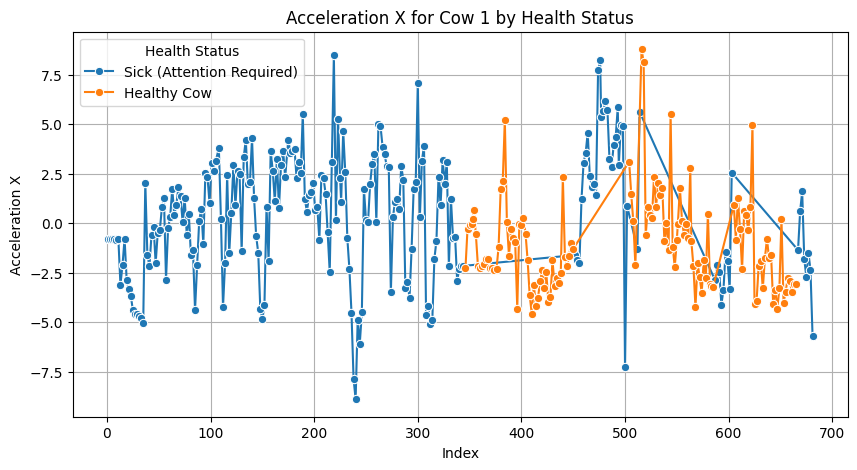

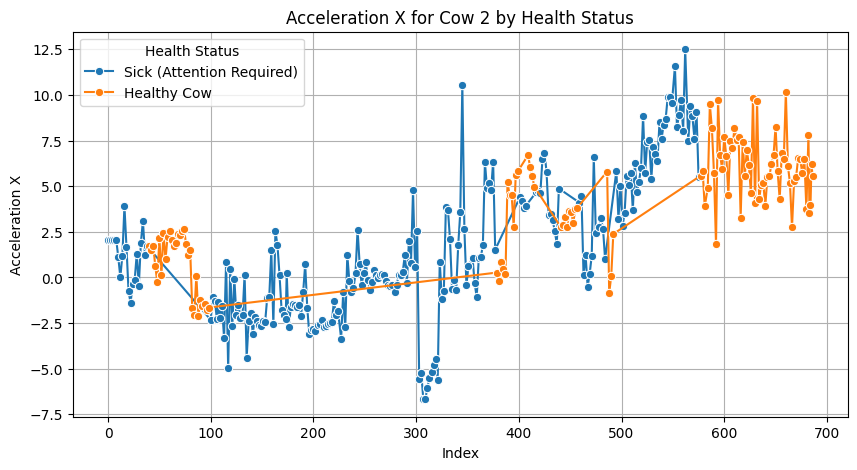

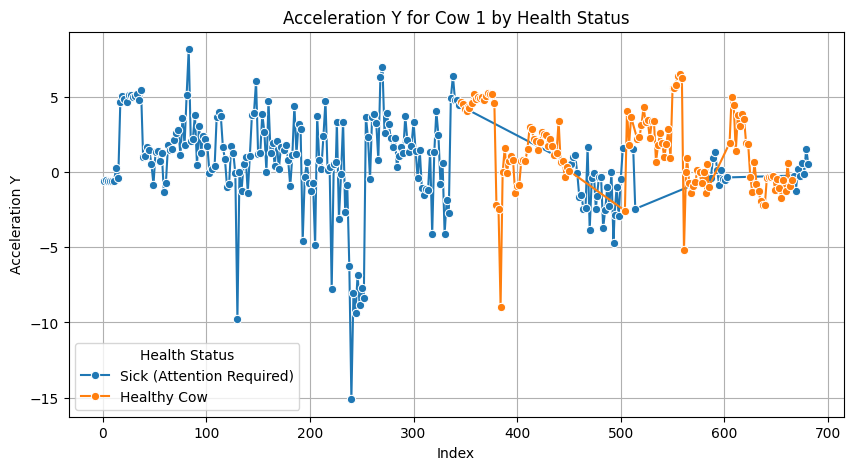

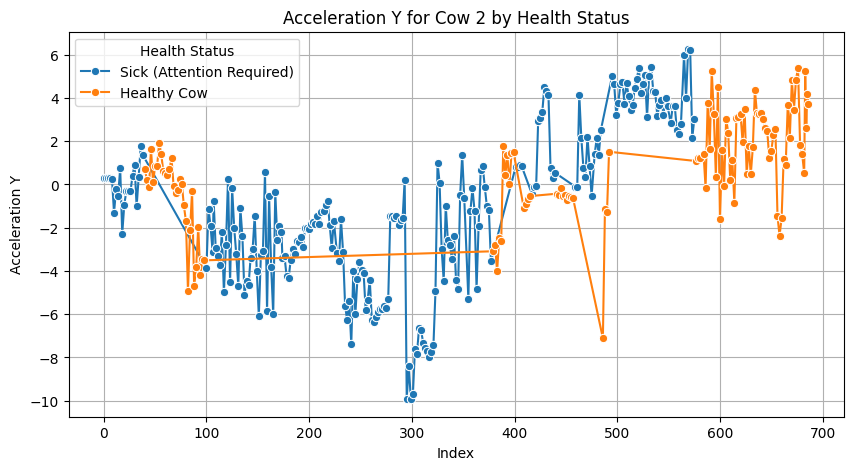

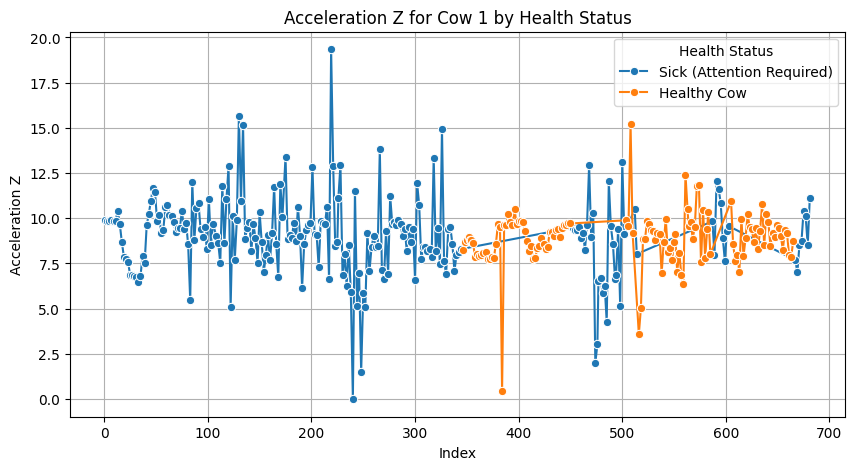

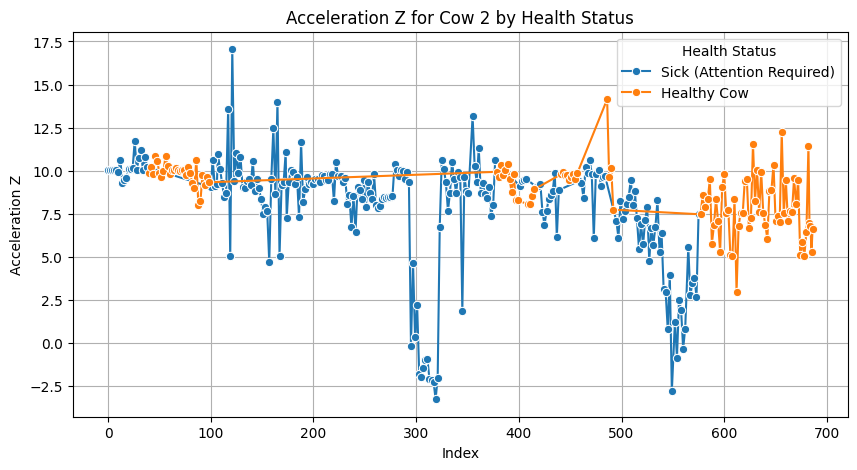

In [3]:
# --- Section 1: Imports ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from micromlgen import port

# --- Section 2: File Paths ---
input_file_path = r'C:\Users\fdkmu\OneDrive\Dummy Data Used.csv'
output_file_path = r'C:\Users\fdkmu\OneDrive\labeledsensor2_data_file.csv'

# --- Section 3: Data Labeling Functions ---
def classify_temperature(temp):
    if temp < 27:
        return 'Low'
    elif temp > 34:
        return 'High'
    else:
        return 'Normal'

def calculate_activity_magnitude(row):
    return np.sqrt(row['AcclX']**2 + row['AcclY']**2 + row['AcclZ']**2)

def categorize_activity(magnitude):
    if magnitude < 7:
        return 'Low'
    elif magnitude > 10:
        return 'High'
    else:
        return 'Normal'

def label_health_status(row):
    temp_status = classify_temperature(row['Temperature'])
    activity_magnitude = calculate_activity_magnitude(row)
    activity_status = categorize_activity(activity_magnitude)
    if temp_status == 'Normal' and activity_status in ['Low', 'Normal', 'High']:
        return 'Healthy Cow'
    else:
        return 'Sick (Attention Required)'

# --- Section 4: Load and Label Dataset ---
if os.path.isfile(input_file_path):
    try:
        df = pd.read_csv(input_file_path)
        df['TemperatureStatus'] = df['Temperature'].apply(classify_temperature)
        df['ActivityMagnitude'] = df.apply(calculate_activity_magnitude, axis=1)
        df['ActivityStatus'] = df['ActivityMagnitude'].apply(categorize_activity)
        df['HealthStatus'] = df.apply(label_health_status, axis=1)
        df.to_csv(output_file_path, index=False)
        print(f"File successfully saved to: {output_file_path}")
    except Exception as e:
        print(f"Error processing file: {e}")
else:
    print(f"Input file not found at: {input_file_path}")

# --- Section 5: Train and Save RandomForest Model ---
data = pd.read_csv(output_file_path)
le = LabelEncoder()
data['HealthStatus'] = le.fit_transform(data['HealthStatus'])
X = data[['Temperature', 'ActivityMagnitude']]
y = data['HealthStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), ['Temperature', 'ActivityMagnitude'])
    ])),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=100))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("\nTest Data Performance:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# --- Section 6: Cross-Validation ---
precision_scorer = make_scorer(precision_score, pos_label=1)
recall_scorer = make_scorer(recall_score, pos_label=1)
f1_scorer = make_scorer(f1_score, pos_label=1)

cv_accuracy = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
cv_precision = cross_val_score(pipeline, X, y, cv=5, scoring=precision_scorer)
cv_recall = cross_val_score(pipeline, X, y, cv=5, scoring=recall_scorer)
cv_f1 = cross_val_score(pipeline, X, y, cv=5, scoring=f1_scorer)

print("\nCross-Validation Performance:")
print(f"Accuracy: {cv_accuracy.mean() * 100:.2f}%")
print(f"Precision: {cv_precision.mean():.2f}")
print(f"Recall: {cv_recall.mean():.2f}")
print(f"F1-Score: {cv_f1.mean():.2f}")

joblib.dump(pipeline, 'new2_random_forest_model.pkl')
c_code = port(pipeline.named_steps['classifier'])
with open('new2_random_forest_model2_for_ESP32.c', 'w') as f:
    f.write(c_code)

# --- Section 7: Feature Importance Visualization ---
importances = pipeline.named_steps['classifier'].feature_importances_
features = ['Temperature', 'ActivityMagnitude']
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances from Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# --- Section 8: Clustering Visualization ---
features = ['ActivityMagnitude', 'Temperature', 'AcclX', 'AcclY', 'AcclZ']
X = data[features]
y = data['HealthStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
data['PredictedCluster'] = rf_classifier.predict(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='ActivityMagnitude', y='Temperature', hue='PredictedCluster', palette='viridis')
plt.title("Random Forest Classification of Cows (Predicted Clusters)")
plt.xlabel("Activity Magnitude")
plt.ylabel("Temperature")
plt.show()

# --- Section 9: Health Metrics Comparison Plots ---
data = pd.read_csv(output_file_path)  # reload to get original HealthStatus labels

if 'NodeID' in data.columns:
    data = data[data['HealthStatus'].isin(['Healthy Cow', 'Sick (Attention Required)'])]
    data_cow_1 = data[data['NodeID'] == 1]
    data_cow_2 = data[data['NodeID'] == 2]

    def plot_parameter(data, parameter, title, ylabel, cow_id):
        plt.figure(figsize=(10, 5))
        if 'HealthStatus' in data.columns and not data['HealthStatus'].isnull().all():
            sns.lineplot(data=data, x=data.index, y=parameter, hue='HealthStatus', marker='o', palette='tab10')
            plt.legend(title='Health Status')
        else:
            sns.lineplot(data=data, x=data.index, y=parameter, marker='o')
        plt.title(f"{title} for Cow {cow_id} by Health Status")
        plt.xlabel('Index')
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.show()

    plot_parameter(data_cow_1, 'ActivityMagnitude', 'Activity Magnitude', 'Activity Magnitude', 1)
    plot_parameter(data_cow_2, 'ActivityMagnitude', 'Activity Magnitude', 'Activity Magnitude', 2)
    plot_parameter(data_cow_1, 'Temperature', 'Temperature', 'Temperature (°C)', 1)
    plot_parameter(data_cow_2, 'Temperature', 'Temperature', 'Temperature (°C)', 2)
    plot_parameter(data_cow_1, 'AcclX', 'Acceleration X', 'Acceleration X', 1)
    plot_parameter(data_cow_2, 'AcclX', 'Acceleration X', 'Acceleration X', 2)
    plot_parameter(data_cow_1, 'AcclY', 'Acceleration Y', 'Acceleration Y', 1)
    plot_parameter(data_cow_2, 'AcclY', 'Acceleration Y', 'Acceleration Y', 2)
    plot_parameter(data_cow_1, 'AcclZ', 'Acceleration Z', 'Acceleration Z', 1)
    plot_parameter(data_cow_2, 'AcclZ', 'Acceleration Z', 'Acceleration Z', 2)




